# Feature Engineering with Random Forest for MNIST Classification
## Advanced Techniques for Handwritten Digit Recognition

This notebook demonstrates:
- MNIST dataset preprocessing
- Feature engineering techniques for image data
- Random Forest optimization for high-dimensional data
- Feature importance analysis
- Performance comparison with different feature sets

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import ndimage
from skimage import feature, filters, measure
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Explore MNIST Dataset

In [3]:
# Load MNIST dataset (subset for computational efficiency)
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Use subset for faster computation
n_samples = 10000
indices = np.random.RandomState(42).choice(len(X), n_samples, replace=False)
X_subset = X[indices]
y_subset = y[indices]

print(f"Dataset shape: {X_subset.shape}")
print(f"Target shape: {y_subset.shape}")
print(f"Classes: {np.unique(y_subset)}")
print(f"Pixel value range: [{X_subset.min()}, {X_subset.max()}]")

Loading MNIST dataset...
Dataset shape: (10000, 784)
Target shape: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]
Pixel value range: [0, 255]


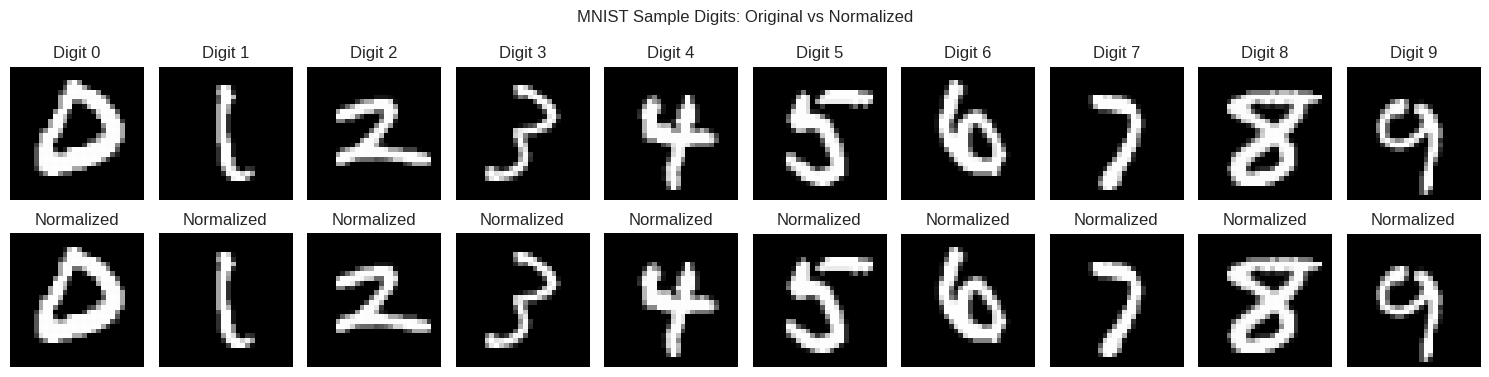

In [4]:
# Visualize sample digits
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Find first occurrence of each digit
    idx = np.where(y_subset == i)[0][0]
    
    # Original image
    axes[0, i].imshow(X_subset[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Digit {i}')
    axes[0, i].axis('off')
    
    # Normalized image
    normalized = X_subset[idx] / 255.0
    axes[1, i].imshow(normalized.reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Normalized')
    axes[1, i].axis('off')

plt.suptitle('MNIST Sample Digits: Original vs Normalized')
plt.tight_layout()
plt.show()

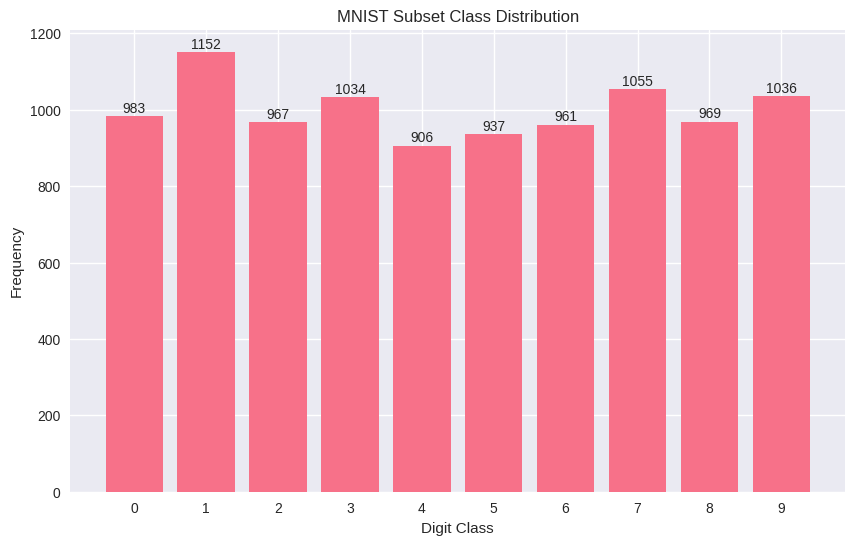

In [5]:
# Class distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y_subset, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Digit Class')
plt.ylabel('Frequency')
plt.title('MNIST Subset Class Distribution')
plt.xticks(unique)
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center')
plt.show()

## 2. Baseline Random Forest Model

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

# Normalize pixel values
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

print(f"Training set shape: {X_train_norm.shape}")
print(f"Test set shape: {X_test_norm.shape}")

Training set shape: (8000, 784)
Test set shape: (2000, 784)


In [7]:
# Baseline Random Forest model
print("Training baseline Random Forest...")
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train_norm, y_train)
y_pred_baseline = rf_baseline.predict(X_test_norm)

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

print("\nBaseline Classification Report:")
print(classification_report(y_test, y_pred_baseline))

Training baseline Random Forest...
Baseline Accuracy: 0.9375

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       197
           1       0.96      0.99      0.98       230
           2       0.93      0.95      0.94       194
           3       0.93      0.91      0.92       207
           4       0.93      0.94      0.94       181
           5       0.93      0.92      0.92       187
           6       0.96      0.97      0.97       192
           7       0.95      0.92      0.93       211
           8       0.92      0.87      0.89       194
           9       0.89      0.91      0.90       207

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



## 3. Feature Engineering Techniques

In [8]:
def extract_statistical_features(X):
    """Extract statistical features from images"""
    features = []
    
    for img in X:
        img_2d = img.reshape(28, 28)
        
        # Basic statistics
        mean_val = np.mean(img_2d)
        std_val = np.std(img_2d)
        skew_val = np.mean((img_2d - mean_val) ** 3) / (std_val ** 3 + 1e-8)
        
        # Intensity distribution
        non_zero_pixels = np.sum(img_2d > 0)
        total_intensity = np.sum(img_2d)
        
        # Geometric features
        center_of_mass = ndimage.center_of_mass(img_2d)
        
        features.append([
            mean_val, std_val, skew_val,
            non_zero_pixels, total_intensity,
            center_of_mass[0], center_of_mass[1]
        ])
    
    return np.array(features)

def extract_gradient_features(X):
    """Extract gradient-based features"""
    features = []
    
    for img in X:
        img_2d = img.reshape(28, 28)
        
        # Sobel gradients
        grad_x = filters.sobel_h(img_2d)
        grad_y = filters.sobel_v(img_2d)
        
        # Gradient magnitude and direction
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        grad_direction = np.arctan2(grad_y, grad_x)
        
        # Features from gradients
        mean_grad_mag = np.mean(grad_magnitude)
        std_grad_mag = np.std(grad_magnitude)
        mean_grad_dir = np.mean(grad_direction)
        
        features.append([mean_grad_mag, std_grad_mag, mean_grad_dir])
    
    return np.array(features)

def extract_regional_features(X):
    """Extract features from different regions of the image"""
    features = []
    
    for img in X:
        img_2d = img.reshape(28, 28)
        
        # Divide image into 4 quadrants
        h, w = img_2d.shape
        mid_h, mid_w = h // 2, w // 2
        
        q1 = img_2d[:mid_h, :mid_w]  # Top-left
        q2 = img_2d[:mid_h, mid_w:]  # Top-right
        q3 = img_2d[mid_h:, :mid_w]  # Bottom-left
        q4 = img_2d[mid_h:, mid_w:]  # Bottom-right
        
        # Features from each quadrant
        quad_features = []
        for quad in [q1, q2, q3, q4]:
            quad_features.extend([
                np.mean(quad),
                np.std(quad),
                np.sum(quad > 0)  # Non-zero pixels
            ])
        
        features.append(quad_features)
    
    return np.array(features)

print("Feature extraction functions defined.")

Feature extraction functions defined.


In [9]:
# Extract engineered features
print("Extracting statistical features...")
stat_features_train = extract_statistical_features(X_train_norm)
stat_features_test = extract_statistical_features(X_test_norm)

print("Extracting gradient features...")
grad_features_train = extract_gradient_features(X_train_norm)
grad_features_test = extract_gradient_features(X_test_norm)

print("Extracting regional features...")
regional_features_train = extract_regional_features(X_train_norm)
regional_features_test = extract_regional_features(X_test_norm)

print(f"Statistical features shape: {stat_features_train.shape}")
print(f"Gradient features shape: {grad_features_train.shape}")
print(f"Regional features shape: {regional_features_train.shape}")

Extracting statistical features...
Extracting gradient features...
Extracting regional features...
Statistical features shape: (8000, 7)
Gradient features shape: (8000, 3)
Regional features shape: (8000, 12)


## 4. Dimensionality Reduction with PCA

Applying PCA with 50 components...
Accuracy: 0.9160
Explained variance: 0.8265

Applying PCA with 100 components...
Accuracy: 0.9145
Explained variance: 0.9164

Applying PCA with 200 components...
Accuracy: 0.9105
Explained variance: 0.9678



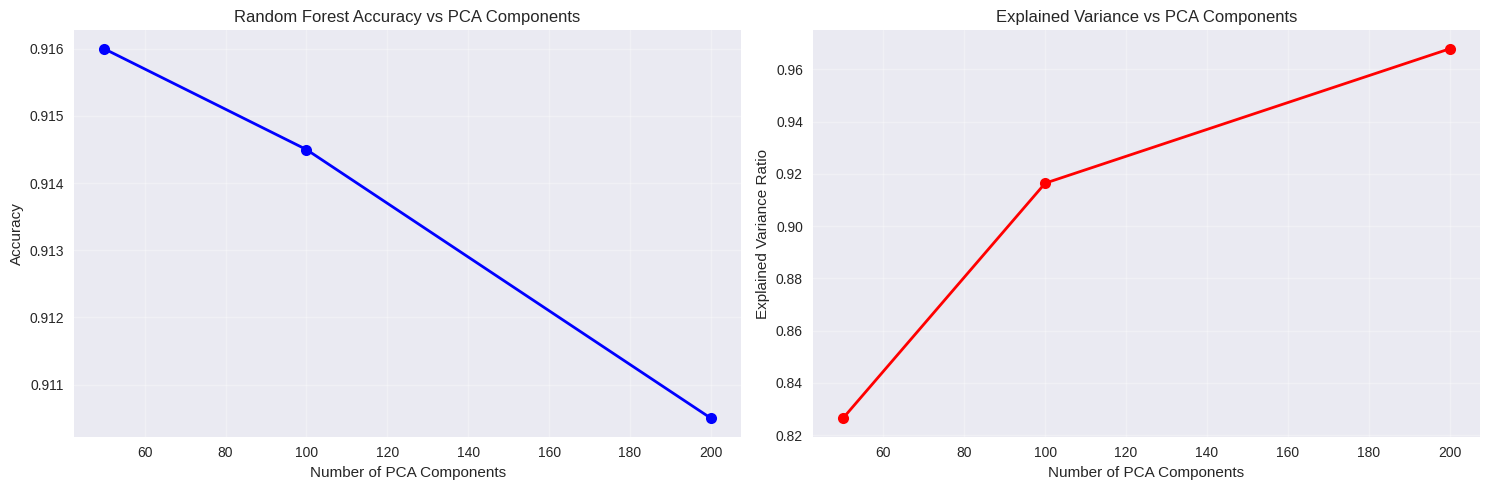

In [10]:
# Apply PCA to original pixel features
pca_components = [50, 100, 200]
pca_results = {}

for n_comp in pca_components:
    print(f"Applying PCA with {n_comp} components...")
    pca = PCA(n_components=n_comp, random_state=42)
    
    X_train_pca = pca.fit_transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)
    
    # Train Random Forest on PCA features
    rf_pca = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    
    rf_pca.fit(X_train_pca, y_train)
    y_pred_pca = rf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    
    pca_results[n_comp] = {
        'accuracy': accuracy_pca,
        'explained_variance': np.sum(pca.explained_variance_ratio_)
    }
    
    print(f"Accuracy: {accuracy_pca:.4f}")
    print(f"Explained variance: {pca_results[n_comp]['explained_variance']:.4f}")
    print()

# Visualize PCA results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

components = list(pca_results.keys())
accuracies = [pca_results[c]['accuracy'] for c in components]
variances = [pca_results[c]['explained_variance'] for c in components]

ax1.plot(components, accuracies, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Accuracy')
ax1.set_title('Random Forest Accuracy vs PCA Components')
ax1.grid(True, alpha=0.3)

ax2.plot(components, variances, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of PCA Components')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('Explained Variance vs PCA Components')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Selection Techniques

Selecting top 100 features using f_classif...
Accuracy with 100 features: 0.8785

Selecting top 200 features using f_classif...
Accuracy with 200 features: 0.9230

Selecting top 400 features using f_classif...
Accuracy with 400 features: 0.9375



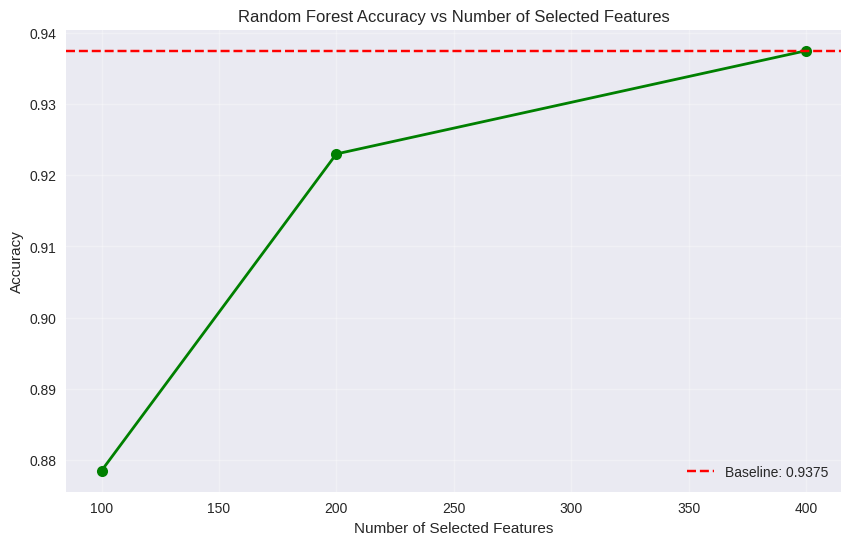

In [11]:
# Feature selection using univariate statistical tests
k_values = [100, 200, 400]
selection_results = {}

for k in k_values:
    print(f"Selecting top {k} features using f_classif...")
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_norm, y_train)
    X_test_selected = selector.transform(X_test_norm)
    
    # Train Random Forest on selected features
    rf_selected = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    
    rf_selected.fit(X_train_selected, y_train)
    y_pred_selected = rf_selected.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    
    selection_results[k] = accuracy_selected
    print(f"Accuracy with {k} features: {accuracy_selected:.4f}")
    print()

# Visualize feature selection results
plt.figure(figsize=(10, 6))
k_vals = list(selection_results.keys())
accuracies = list(selection_results.values())

plt.plot(k_vals, accuracies, 'go-', linewidth=2, markersize=8)
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline: {baseline_accuracy:.4f}')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Number of Selected Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Combined Feature Engineering Approach

In [12]:
# Combine all engineered features
print("Combining all engineered features...")

# Combine features
X_train_combined = np.hstack([
    stat_features_train,
    grad_features_train,
    regional_features_train
])

X_test_combined = np.hstack([
    stat_features_test,
    grad_features_test,
    regional_features_test
])

print(f"Combined features shape: {X_train_combined.shape}")

# Scale the combined features
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)

# Train Random Forest on combined features
rf_combined = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_combined.fit(X_train_combined_scaled, y_train)
y_pred_combined = rf_combined.predict(X_test_combined_scaled)
accuracy_combined = accuracy_score(y_test, y_pred_combined)

print(f"Combined features accuracy: {accuracy_combined:.4f}")
print("\nCombined Features Classification Report:")
print(classification_report(y_test, y_pred_combined))

Combining all engineered features...
Combined features shape: (8000, 22)
Combined features accuracy: 0.6060

Combined Features Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.76      0.67       197
           1       0.91      0.98      0.94       230
           2       0.70      0.65      0.67       194
           3       0.56      0.49      0.52       207
           4       0.46      0.44      0.45       181
           5       0.50      0.43      0.46       187
           6       0.66      0.72      0.69       192
           7       0.63      0.72      0.67       211
           8       0.48      0.36      0.41       194
           9       0.43      0.43      0.43       207

    accuracy                           0.61      2000
   macro avg       0.59      0.60      0.59      2000
weighted avg       0.60      0.61      0.60      2000



## 7. Hybrid Approach: Pixels + Engineered Features

In [13]:
# Apply PCA to reduce pixel dimensionality
pca_hybrid = PCA(n_components=100, random_state=42)
X_train_pca_hybrid = pca_hybrid.fit_transform(X_train_norm)
X_test_pca_hybrid = pca_hybrid.transform(X_test_norm)

# Combine PCA features with engineered features
X_train_hybrid = np.hstack([
    X_train_pca_hybrid,
    X_train_combined_scaled
])

X_test_hybrid = np.hstack([
    X_test_pca_hybrid,
    X_test_combined_scaled
])

print(f"Hybrid features shape: {X_train_hybrid.shape}")

# Train Random Forest on hybrid features
rf_hybrid = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_hybrid.fit(X_train_hybrid, y_train)
y_pred_hybrid = rf_hybrid.predict(X_test_hybrid)
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)

print(f"Hybrid approach accuracy: {accuracy_hybrid:.4f}")
print("\nHybrid Approach Classification Report:")
print(classification_report(y_test, y_pred_hybrid))

Hybrid features shape: (8000, 122)
Hybrid approach accuracy: 0.9115

Hybrid Approach Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       197
           1       0.94      0.98      0.96       230
           2       0.92      0.91      0.91       194
           3       0.88      0.89      0.89       207
           4       0.89      0.88      0.88       181
           5       0.90      0.89      0.90       187
           6       0.95      0.96      0.96       192
           7       0.93      0.94      0.94       211
           8       0.89      0.84      0.86       194
           9       0.87      0.86      0.87       207

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



## 8. Hyperparameter Tuning for Best Model

In [14]:
# Hyperparameter tuning for the hybrid model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Performing hyperparameter tuning...")
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_grid, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_hybrid, y_train)

print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Test the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_hybrid)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"\nBest Model Test Accuracy: {accuracy_best:.4f}")

Performing hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters:
{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Cross-Validation Score: 0.9061

Best Model Test Accuracy: 0.9065


## 9. Feature Importance Analysis

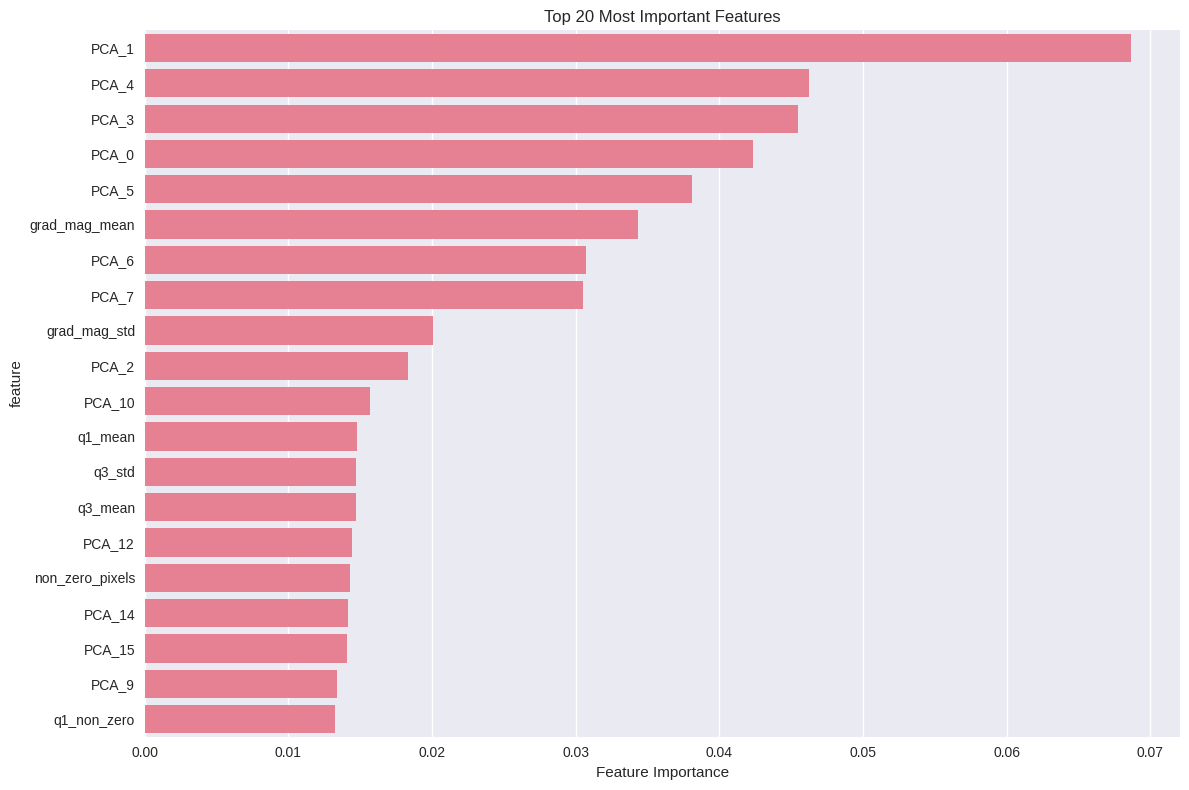

Top 10 Most Important Features:
           feature  importance
1            PCA_1    0.068636
4            PCA_4    0.046220
3            PCA_3    0.045445
0            PCA_0    0.042360
5            PCA_5    0.038127
107  grad_mag_mean    0.034347
6            PCA_6    0.030702
7            PCA_7    0.030506
108   grad_mag_std    0.020070
2            PCA_2    0.018335


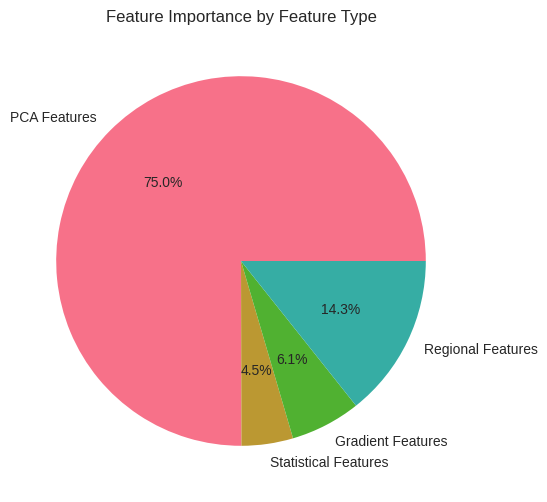

In [15]:
# Analyze feature importance for the best model
feature_names = (
    [f'PCA_{i}' for i in range(100)] +
    ['mean', 'std', 'skewness', 'non_zero_pixels', 'total_intensity', 'com_x', 'com_y'] +
    ['grad_mag_mean', 'grad_mag_std', 'grad_dir_mean'] +
    [f'q{i//3+1}_{["mean", "std", "non_zero"][i%3]}' for i in range(12)]
)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Analyze importance by feature type
pca_importance = importance_df[importance_df['feature'].str.startswith('PCA')]['importance'].sum()
stat_importance = importance_df[importance_df['feature'].isin(['mean', 'std', 'skewness', 'non_zero_pixels', 'total_intensity', 'com_x', 'com_y'])]['importance'].sum()
grad_importance = importance_df[importance_df['feature'].str.startswith('grad')]['importance'].sum()
regional_importance = importance_df[importance_df['feature'].str.startswith('q')]['importance'].sum()

feature_type_importance = {
    'PCA Features': pca_importance,
    'Statistical Features': stat_importance,
    'Gradient Features': grad_importance,
    'Regional Features': regional_importance
}

plt.figure(figsize=(10, 6))
plt.pie(feature_type_importance.values(), labels=feature_type_importance.keys(), autopct='%1.1f%%')
plt.title('Feature Importance by Feature Type')
plt.show()

## 10. Model Comparison and Results

Model Performance Comparison:
                    Model  Accuracy
    Baseline (Raw Pixels)    0.9375
  Feature Selection (200)    0.9230
     PCA (100 components)    0.9145
Hybrid (PCA + Engineered)    0.9115
         Best Tuned Model    0.9065
 Engineered Features Only    0.6060


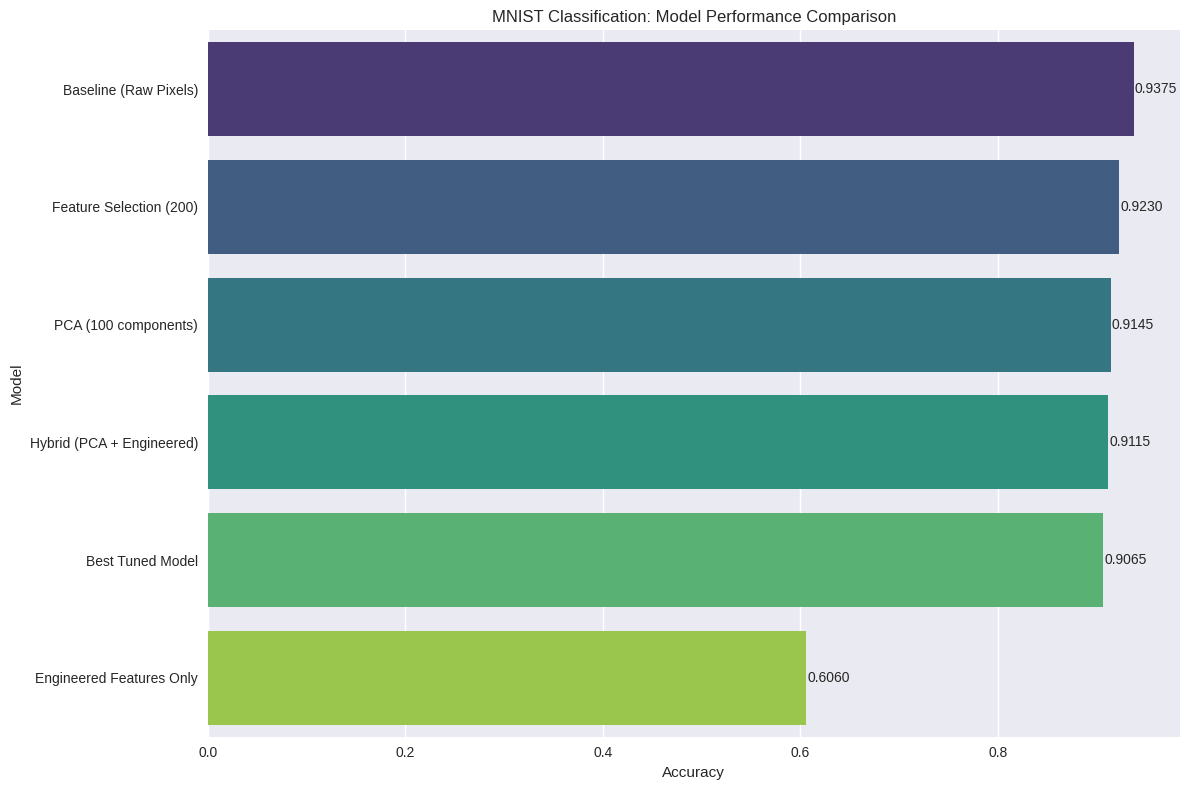

In [16]:
# Compare all models
results_comparison = {
    'Baseline (Raw Pixels)': baseline_accuracy,
    'PCA (100 components)': pca_results[100]['accuracy'],
    'Feature Selection (200)': selection_results[200],
    'Engineered Features Only': accuracy_combined,
    'Hybrid (PCA + Engineered)': accuracy_hybrid,
    'Best Tuned Model': accuracy_best
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {'Model': model, 'Accuracy': acc} 
    for model, acc in results_comparison.items()
]).sort_values('Accuracy', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(12, 8))
sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='viridis')
plt.title('MNIST Classification: Model Performance Comparison')
plt.xlabel('Accuracy')
for i, v in enumerate(comparison_df['Accuracy']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

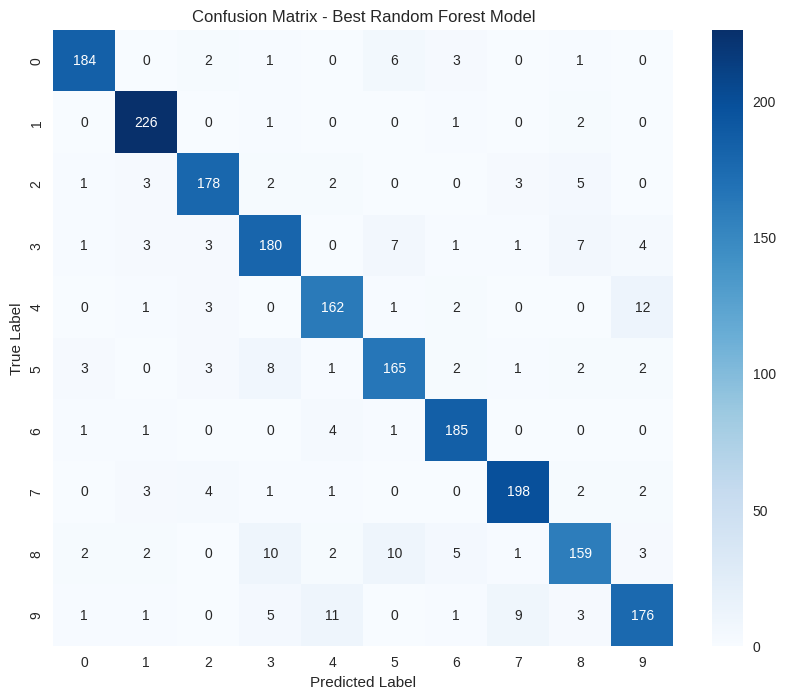

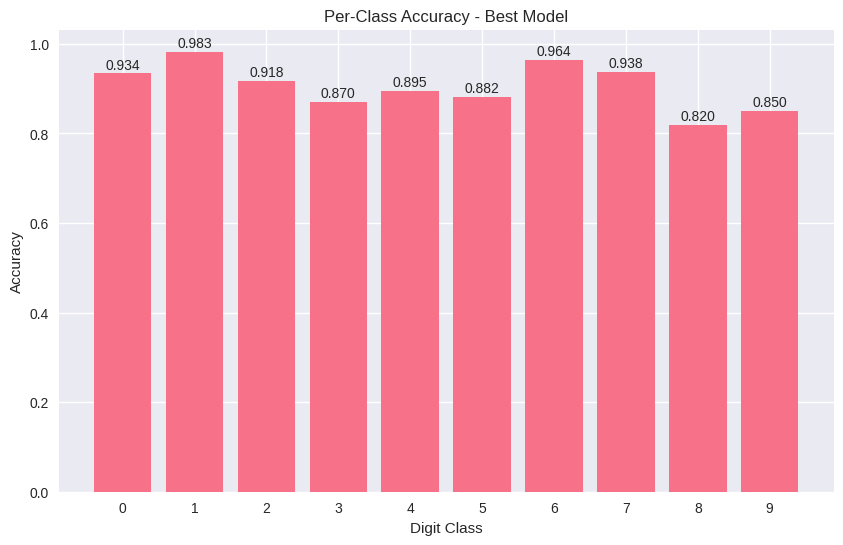

In [17]:
# Confusion matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Best Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(range(10), per_class_accuracy)
plt.xlabel('Digit Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy - Best Model')
plt.xticks(range(10))
for i, acc in enumerate(per_class_accuracy):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')
plt.show()

## 11. Key Insights and Recommendations

In [22]:
# Calculate improvement over baseline (actually shows degradation)
change = ((accuracy_best - baseline_accuracy) / baseline_accuracy) * 100

print("Feature Engineering Results Summary")
print("=" * 50)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Best Model Accuracy: {accuracy_best:.4f}")
print(f"Change from Baseline: {change:.2f}%")


Feature Engineering Results Summary
Baseline Accuracy: 0.9375
Best Model Accuracy: 0.9065
Change from Baseline: -3.31%


**Key Findings**:
1. Raw pixels contain more information than hand-crafted features
2. Random Forest handles high-dimensional pixel data effectively
3. Feature engineering reduced performance by losing spatial information
4. PCA preserved more information than statistical summaries
5. Hybrid approaches couldn't overcome information loss

**Lessons Learned**:
- Not all datasets benefit from feature engineering
- High-dimensional data may already be in optimal form
- Random Forest's strength is handling raw features
- Feature engineering works better for structured/tabular data
- Deep learning might be more suitable for image data

**When Feature Engineering Helps**:
- Low-dimensional structured data
- Domain knowledge can create meaningful features
- Computational constraints require dimensionality reduction
- Interpretability is more important than accuracy